In [61]:
import numpy as np
import flory
import sys
import matplotlib.pyplot as plt
import mpltern
import h5py


sys.path.append('/Users/calvinsmith/dufresne_lab/phase_space_search/')
import flory_classifier_v2
import flory_phase_space
from flory_classifier_v2 import FloryClassifier 
from flory_phase_space import PhaseSpace

import flory_phase_data
from flory_phase_data import PhaseData

sys.path.append('/Users/calvinsmith/dufresne_lab/lab_work/llps_classification')
import flory_generate as gen

def generate_simplex_grid(num_comps, num_points):
    """Generates a properly spaced grid over the num_comps-simplex."""
    
    # Choose an integer N for the lattice grid spacing
    N = int(round(num_points ** (1 / (num_comps - 1))))  # Estimate good spacing

    # Generate integer partitions of N into num_comps parts
    partitions = itertools.combinations_with_replacement(range(N + 1), num_comps - 1)

    grid = []
    for partition in partitions:
        full_partition = [partition[0]] + [partition[i] - partition[i-1] for i in range(1, len(partition))] + [N - partition[-1]]
        grid.append(np.array(full_partition) / N)  # Normalize to sum to 1

    grid = np.array(grid)
    
    # Shuffle and select the required number of points
    np.random.shuffle(grid)
    return grid[:num_points]  # Return the requested number of points



2.0.0


In [63]:
num_comps = 3
num_points = 100  # Adjust as needed
grid = generate_simplex_grid(num_comps, num_points)

print(grid)


[[0.6 0.  0.4]
 [0.5 0.4 0.1]
 [0.1 0.5 0.4]
 [0.2 0.2 0.6]
 [0.7 0.3 0. ]
 [0.4 0.3 0.3]
 [0.1 0.7 0.2]
 [0.7 0.2 0.1]
 [0.4 0.2 0.4]
 [0.9 0.1 0. ]
 [0.6 0.3 0.1]
 [0.5 0.  0.5]
 [1.  0.  0. ]
 [0.3 0.  0.7]
 [0.  0.9 0.1]
 [0.2 0.5 0.3]
 [0.7 0.1 0.2]
 [0.1 0.4 0.5]
 [0.4 0.6 0. ]
 [0.  0.6 0.4]
 [0.2 0.4 0.4]
 [0.5 0.2 0.3]
 [0.1 0.6 0.3]
 [0.3 0.1 0.6]
 [0.  0.7 0.3]
 [0.  0.4 0.6]
 [0.  1.  0. ]
 [0.3 0.6 0.1]
 [0.6 0.1 0.3]
 [0.  0.8 0.2]
 [0.1 0.1 0.8]
 [0.5 0.1 0.4]
 [0.8 0.1 0.1]
 [0.6 0.2 0.2]
 [0.3 0.5 0.2]
 [0.3 0.7 0. ]
 [0.2 0.3 0.5]
 [0.3 0.3 0.4]
 [0.8 0.2 0. ]
 [0.  0.  1. ]
 [0.5 0.5 0. ]
 [0.4 0.4 0.2]
 [0.  0.5 0.5]
 [0.6 0.4 0. ]
 [0.1 0.  0.9]
 [0.2 0.8 0. ]
 [0.2 0.1 0.7]
 [0.  0.1 0.9]
 [0.5 0.3 0.2]
 [0.7 0.  0.3]
 [0.  0.2 0.8]
 [0.3 0.2 0.5]
 [0.4 0.1 0.5]
 [0.1 0.8 0.1]
 [0.8 0.  0.2]
 [0.1 0.3 0.6]
 [0.1 0.2 0.7]
 [0.  0.3 0.7]
 [0.9 0.  0.1]
 [0.2 0.  0.8]
 [0.2 0.7 0.1]
 [0.4 0.5 0.1]
 [0.3 0.4 0.3]
 [0.4 0.  0.6]
 [0.1 0.9 0. ]
 [0.2 0.6 0.2]]


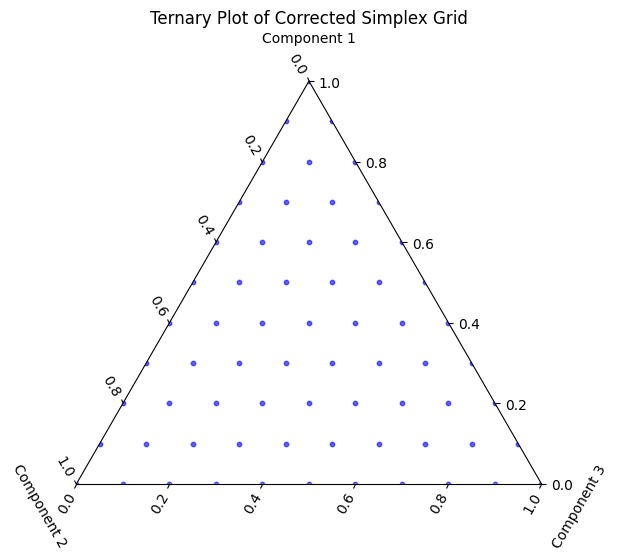

In [64]:

# Plot the ternary diagram
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'ternary'})

# Scatter plot of simplex grid points
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], color='blue', alpha=0.6, s=10)

# Set ternary axis labels
ax.set_tlabel("Component 1")
ax.set_llabel("Component 2")
ax.set_rlabel("Component 3")

# Title
ax.set_title("Ternary Plot of Corrected Simplex Grid")

# Show plot
plt.show()

In [69]:

def generate_grid_data_N_Dim( num_chi_matrix=1, num_points=100, plot_flag=False):
    num_comps = 3 
    chi_strength = 4

    chi_set = np.empty(num_chi_matrix, dtype = object)
    for j in range(num_chi_matrix):
        chi_matrix = chi_strength*np.random.rand(num_comps,num_comps)
        chi_matrix = np.transpose(chi_matrix) + chi_matrix
        for i in range(num_comps):
            chi_matrix[i,i] = 0
        chi_set[j] = chi_matrix

    # Use simplex grid instead of random points
    points = generate_simplex_grid(num_comps, num_points)

    evolved_points = np.empty((num_chi_matrix, num_points), dtype=object)

    for i in range(num_chi_matrix):
        for j in range(num_points):
            evolved_points[i, j] = flory.find_coexisting_phases(num_comps, chi_matrix, points[j, :], progress=False)

    data = PhaseData(chi_matrix, points, evolved_points)

    folder_path = "/Users/calvinsmith/dufresne_lab/phase_space_search/Saved_Phase_Data/"
    file_path = folder_path + "test_phase_data_v2.h5"
    hf = h5py.File(file_path, 'w')

    for i in range(num_chi_matrix):
        g1 = hf.create_group(f"chi_matrix_{i}")
        g2 = g1.create_group("evolved_phases")

    volumes = np.zeros((num_chi_matrix, num_points, num_comps))

    for i in range(num_chi_matrix):
        for j in range(num_points):
            phase = evolved_points[i, j]
            phase_vol = phase.volumes
            volumes[i, j, 0:len(phase_vol)] = phase_vol

    bool_phases_map = (volumes != 0).astype(float)

    num_phases = np.sum(bool_phases_map, axis=-1)

    max_num_phases = np.max(num_phases, axis=1)
    max_indices = np.argmax(num_phases, axis=1)

    max_phases = int(max_num_phases[0])

    phi_comps = np.zeros((num_chi_matrix, num_points, max_phases, num_comps))

    for i in range(num_chi_matrix):
        for j in range(num_points):
            phase = evolved_points[i, j]
            phase_fractions = phase.fractions
            pf_shape = phase_fractions.shape
            phi_comps[i, j, 0:pf_shape[0], 0:pf_shape[1]] = phase_fractions

    for i in range(num_chi_matrix):
        g1 = hf[f"chi_matrix_{i}"]
        g1.create_dataset("initial_points", data=points)
        g1.create_dataset("chi_matrix", data=chi_set[i])
        g2 = g1["evolved_phases"]
        g2.create_dataset("volumes", data=volumes[i])
        g2.create_dataset("comp_fracs", data=phi_comps[i])
        g2.create_dataset("num_phases", data=num_phases[i])

    hf.close()

    if plot_flag:
        folder_path = "/Users/calvinsmith/dufresne_lab/phase_space_search/Saved_Phase_Data/"
        file_path = folder_path + "test_phase_data_v2.h5"

        with h5py.File(file_path, 'r') as hf:
            for chi_key in hf.keys():
                print(f"\n📂 {chi_key}:")  
                g1 = hf[chi_key]

                print("  ├── initial_points:", g1["initial_points"][:].shape)
                print("  ├── chi_matrix:", g1["chi_matrix"][:].shape)

                if "evolved_phases" in g1:
                    g2 = g1["evolved_phases"]
                    print("  ├── evolved_phases:")
                    print("      ├── volumes:", g2["volumes"][:].shape)
                    print("      ├── comp_fracs:", g2["comp_fracs"][:].shape)
                    print("      ├── num_phases:", g2["num_phases"][:].shape)
                    print("      ├── num_phases sample:", g2["num_phases"][:5]) 


In [70]:
generate_grid_data_N_Dim(num_chi_matrix=1, num_points=100, plot_flag=True)

IndexError: index 66 is out of bounds for axis 0 with size 66

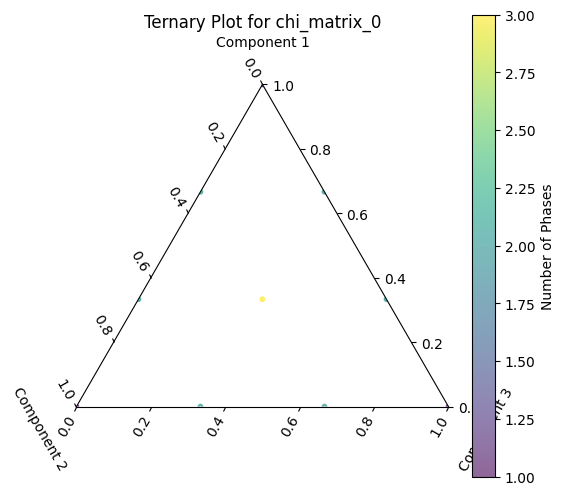

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import mpltern

# Define the file path
folder_path = "/Users/calvinsmith/dufresne_lab/phase_space_search/Saved_Phase_Data/"
file_path = folder_path + "test_phase_data_v2.h5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as hf:
    for chi_key in hf.keys():
        g1 = hf[chi_key]

        # Extract initial points and number of phases
        points = g1["initial_points"][:]
        num_phases = np.ravel(g1["evolved_phases"]["num_phases"][:])  # Flatten to 1D

        # Normalize points for ternary plot (ensure they sum to 1)
        points /= np.sum(points, axis=1, keepdims=True)

        # Create a ternary plot using mpltern
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'ternary'})

        # Plot initial points with color indicating the number of phases
        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                             c=num_phases, cmap='viridis', alpha=0.6, s=10)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Number of Phases")

        # Set ternary axis labels
        ax.set_tlabel("Component 1")
        ax.set_llabel("Component 2")
        ax.set_rlabel("Component 3")

        # Title
        ax.set_title(f"Ternary Plot for {chi_key}")

        # Show plot

In [76]:


num_comps = 3 
chi_strength = 4
num_chi_matrix = 2
num_approx_points = 100

chi_set = np.empty(num_chi_matrix, dtype = object)
for j in range(num_chi_matrix):
    chi_matrix = chi_strength*np.random.rand(num_comps,num_comps)
    chi_matrix = np.transpose(chi_matrix) + chi_matrix
    for i in range(num_comps):
        chi_matrix[i,i] = 0
    chi_set[j] = chi_matrix

# Use simplex grid instead of random points
points = generate_simplex_grid(num_comps, num_approx_points)
num_points = np.shape(points)[0]


In [77]:
print(np.shape(points))

(66, 3)


In [78]:

evolved_points = np.empty((num_chi_matrix, num_points), dtype=object)

for i in range(num_chi_matrix):
    for j in range(num_points):
        evolved_points[i, j] = flory.find_coexisting_phases(num_comps, chi_matrix, points[j, :], progress=False)

data = PhaseData(chi_matrix, points, evolved_points)

folder_path = "/Users/calvinsmith/dufresne_lab/phase_space_search/Saved_Phase_Data/"
file_path = folder_path + "test_phase_data_v2.h5"
hf = h5py.File(file_path, 'w')

for i in range(num_chi_matrix):
    g1 = hf.create_group(f"chi_matrix_{i}")
    g2 = g1.create_group("evolved_phases")

volumes = np.zeros((num_chi_matrix, num_points, num_comps))

for i in range(num_chi_matrix):
    for j in range(num_points):
        phase = evolved_points[i, j]
        phase_vol = phase.volumes
        volumes[i, j, 0:len(phase_vol)] = phase_vol

bool_phases_map = (volumes != 0).astype(float)

num_phases = np.sum(bool_phases_map, axis=-1)

max_num_phases = np.max(num_phases, axis=1)
max_indices = np.argmax(num_phases, axis=1)

max_phases = int(max_num_phases[0])

phi_comps = np.zeros((num_chi_matrix, num_points, max_phases, num_comps))

for i in range(num_chi_matrix):
    for j in range(num_points):
        phase = evolved_points[i, j]
        phase_fractions = phase.fractions
        pf_shape = phase_fractions.shape
        phi_comps[i, j, 0:pf_shape[0], 0:pf_shape[1]] = phase_fractions

for i in range(num_chi_matrix):
    g1 = hf[f"chi_matrix_{i}"]
    g1.create_dataset("initial_points", data=points)
    g1.create_dataset("chi_matrix", data=chi_set[i])
    g2 = g1["evolved_phases"]
    g2.create_dataset("volumes", data=volumes[i])
    g2.create_dataset("comp_fracs", data=phi_comps[i])
    g2.create_dataset("num_phases", data=num_phases[i])

hf.close()
    

NameError: name 'plot_flag' is not defined

In [80]:
folder_path = "/Users/calvinsmith/dufresne_lab/phase_space_search/Saved_Phase_Data/"
file_path = folder_path + "test_phase_data_v2.h5"

with h5py.File(file_path, 'r') as hf:
    for chi_key in hf.keys():
        print(f"\n📂 {chi_key}:")  
        g1 = hf[chi_key]

        print("  ├── initial_points:", g1["initial_points"][:].shape)
        print("  ├── chi_matrix:", g1["chi_matrix"][:].shape)

        if "evolved_phases" in g1:
            g2 = g1["evolved_phases"]
            print("  ├── evolved_phases:")
            print("      ├── volumes:", g2["volumes"][:].shape)
            print("      ├── comp_fracs:", g2["comp_fracs"][:].shape)
            print("      ├── num_phases:", g2["num_phases"][:].shape)
            print("      ├── num_phases sample:", g2["num_phases"][:5]) 



📂 chi_matrix_0:
  ├── initial_points: (66, 3)
  ├── chi_matrix: (3, 3)
  ├── evolved_phases:
      ├── volumes: (66, 3)
      ├── comp_fracs: (66, 3, 3)
      ├── num_phases: (66,)
      ├── num_phases sample: [3. 2. 2. 2. 2.]

📂 chi_matrix_1:
  ├── initial_points: (66, 3)
  ├── chi_matrix: (3, 3)
  ├── evolved_phases:
      ├── volumes: (66, 3)
      ├── comp_fracs: (66, 3, 3)
      ├── num_phases: (66,)
      ├── num_phases sample: [3. 2. 2. 2. 2.]


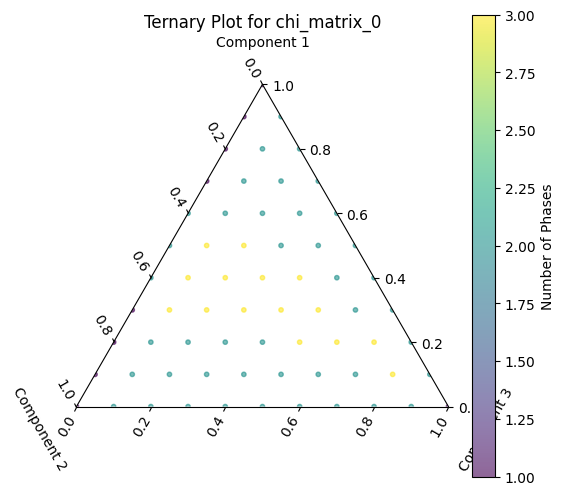

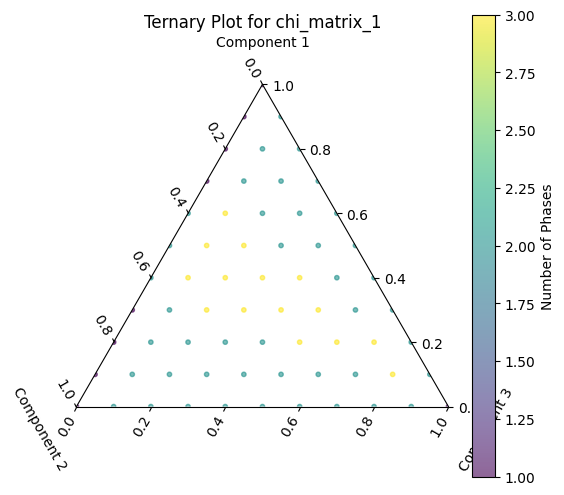

In [81]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import mpltern

# Define the file path
folder_path = "/Users/calvinsmith/dufresne_lab/phase_space_search/Saved_Phase_Data/"
file_path = folder_path + "test_phase_data_v2.h5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as hf:
    for chi_key in hf.keys():
        g1 = hf[chi_key]

        # Extract initial points and number of phases
        points = g1["initial_points"][:]
        num_phases = np.ravel(g1["evolved_phases"]["num_phases"][:])  # Flatten to 1D

        # Normalize points for ternary plot (ensure they sum to 1)
        points /= np.sum(points, axis=1, keepdims=True)

        # Create a ternary plot using mpltern
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'ternary'})

        # Plot initial points with color indicating the number of phases
        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                             c=num_phases, cmap='viridis', alpha=0.6, s=10)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Number of Phases")

        # Set ternary axis labels
        ax.set_tlabel("Component 1")
        ax.set_llabel("Component 2")
        ax.set_rlabel("Component 3")

        # Title
        ax.set_title(f"Ternary Plot for {chi_key}")

        # Show plot